In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

warnings.filterwarnings("ignore")


In [12]:

# === CHARGEMENT DU DATASET ===
file_path = "C:/Users/Massi/Desktop/MSPR BLOC 03/les_jointeurs/datasets/jointeur_elections_population/Dataset_Finale_MSPR_2025.csv"
data = pd.read_csv(file_path, sep=';')

# === FILTRAGE SUR LA BRETAGNE ===
bretagne_depts = ['22', '29', '35', '56']
data['code_dept'] = data['commune_id'].astype(str).str[:2]
data = data[data['code_dept'].isin(bretagne_depts)]


In [13]:

# === ENCODAGE DE LA CIBLE ===
data = data.dropna(subset=['orientation_politique'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['orientation_politique'])
# === STATISTIQUES DES CLASSES ===
class_counts = pd.Series(y).value_counts().sort_index()
print("\n📌 Répartition des classes (encodées) :")
for i, count in class_counts.items():
    print(f"Classe {i} ({label_encoder.inverse_transform([i])[0]}): {count} communes")

# === SELECTION DES VARIABLES ===
features = [
    'Population_Totale','nb_inscrits', 'nb_abstentions', 'pct_population_senior', 'nb_population_active',
    'pct_population_sans_activite', 'pct_population_etrangere',
    'taux_chomage_pct', 'nb_crimes'
]
X = data[features].copy()

# === IMPUTATION ===
X = X.fillna(X.median())




📌 Répartition des classes (encodées) :
Classe 0 (0.0): 176 communes
Classe 1 (2.0): 1733 communes
Classe 2 (3.0): 121 communes
Classe 3 (4.0): 382 communes


In [14]:
# === SEPARATION TRAIN / TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === STANDARDISATION ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === MODELISATION XGBOOST AVEC REGULARISATION ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cpu'
)

# === ENTRAINEMENT ===
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
xgb_model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:

# === PREDICTION ===
y_pred = xgb_model.predict(X_test_scaled)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# === AFFICHAGE ACCURACY ===
print("\n📊 Rapport de classification:")
print(classification_report(y_test_labels, y_pred_labels))
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))



📊 Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.45      0.14      0.22        35
         2.0       0.74      0.98      0.84       347
         3.0       0.00      0.00      0.00        24
         4.0       0.70      0.09      0.16        77

    accuracy                           0.73       483
   macro avg       0.47      0.30      0.31       483
weighted avg       0.68      0.73      0.65       483


🎯 Accuracy: 0.7308488612836439


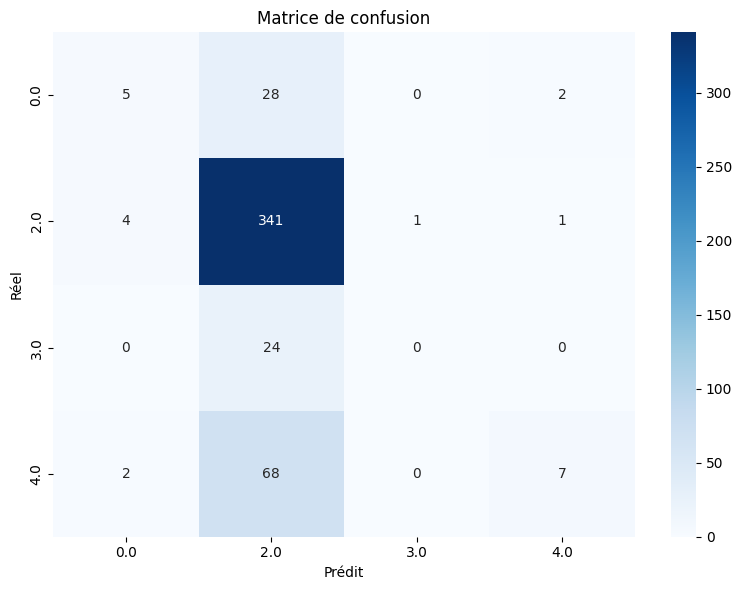

In [16]:

# === MATRICE DE CONFUSION ===
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


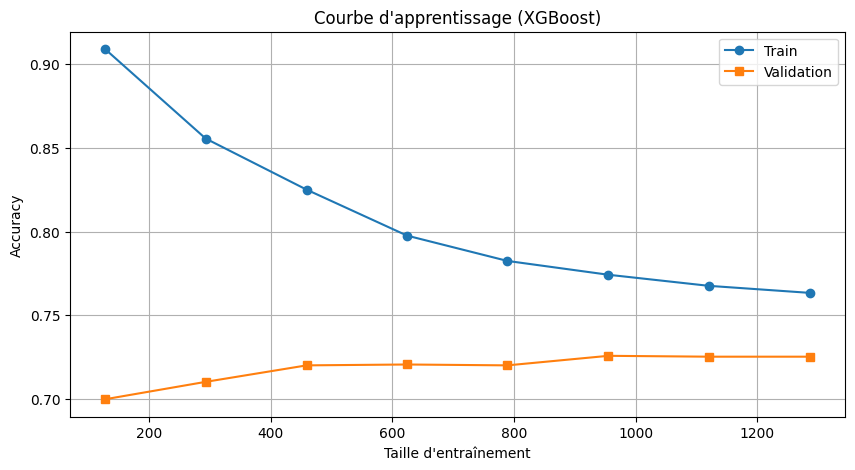

In [17]:

# === COURBE D'APPRENTISSAGE ===
train_sizes, train_scores, val_scores = learning_curve(
    xgb_model, X_train_scaled, y_train, cv=3,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy'
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, label="Train", marker='o')
plt.plot(train_sizes, val_mean, label="Validation", marker='s')
plt.title("Courbe d'apprentissage (XGBoost)")
plt.xlabel("Taille d'entraînement")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


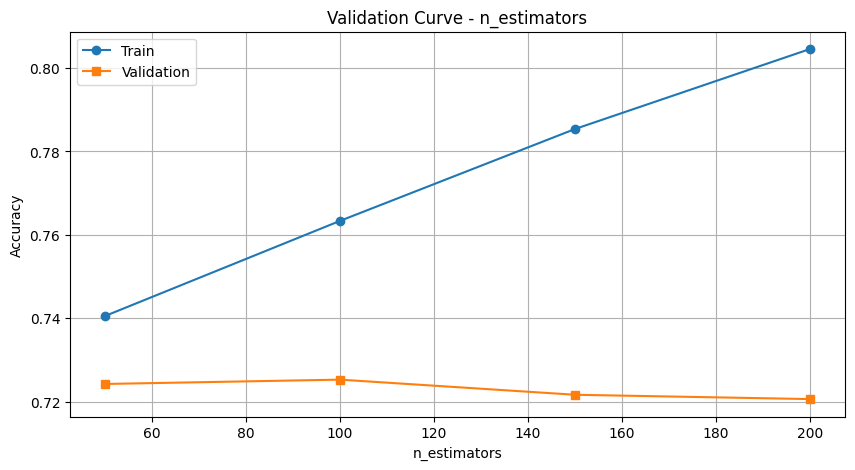

In [18]:

# === COURBE DE VALIDATION ===
n_estimators_range = [50, 100, 150, 200]
train_scores_val, val_scores_val = validation_curve(
    xgb_model, X_train_scaled, y_train,
    param_name='n_estimators',
    param_range=n_estimators_range,
    cv=3, scoring='accuracy'
)
train_mean_val = np.mean(train_scores_val, axis=1)
val_mean_val = np.mean(val_scores_val, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, train_mean_val, label="Train", marker='o')
plt.plot(n_estimators_range, val_mean_val, label="Validation", marker='s')
plt.title("Validation Curve - n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


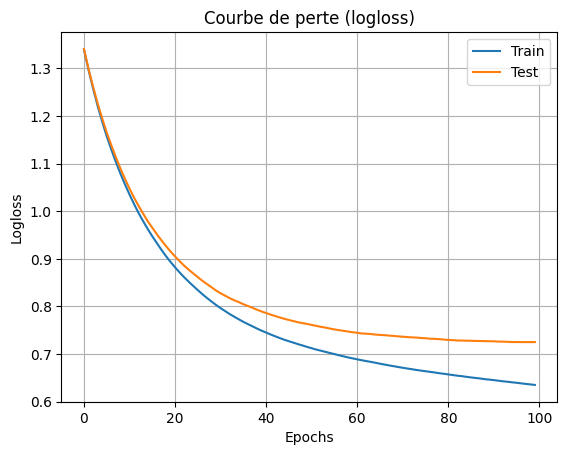

In [19]:

# === COURBE DE PERTE ===
results = xgb_model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Test')
plt.title("Courbe de perte (logloss)")
plt.xlabel("Epochs")
plt.ylabel("Logloss")
plt.legend()
plt.grid()
plt.show()